# Exponential Decay based on temperature

In [1]:
from os import system
import pickle

## PFLOTRAN
import jupypft.model as mo
import jupypft.parameter as pm
import jupypft.plotBTC as plotBTC

def resetPickle():
    mo.Model.resetListOfModels()
    global caseDict
    with open('caseDict.pkl', 'rb') as f:
        caseDict = pickle.load(f)
    
    pm.Parameter.rebuildListOfObjects(caseDict)
    
    global listOfAllParameters
    listOfAllParameters = pm.Parameter.list_of_vars()
    
    system("rm -rf CASE*")
    
def plotResults():
    system("rm -rf MASSBALANCES; mkdir MASSBALANCES")
    system("cp ./CASE**/*-mas.dat ./MASSBALANCES")
    mo.Model.folderFixedToCSV("MASSBALANCES")

    waterDensity = 999.65
    m3ToL = 1000.

    plotBTC.plotMassBalancesInFolder(
        folderToPlot="MASSBALANCES",
        indices = {'t':"Time [d]",\
                   'q':"ExtractWell Water Mass [kg/d]",\
                   'm':"ExtractWell Vaq [mol/d]"},
        normalizeWith={'t':1.0,'q':waterDensity/m3ToL,'m':1.0},
        legendTitle = legendTitle)
    
def buildSim(caseName):
    ## Create a folder for the case
    currentFolder = "./CASE_{0}".format(caseName)
    currentFile = currentFolder + "/" + caseName +".in"
    system("mkdir " + currentFolder)
    
    ## Initialize PFLOTRAN model
    BoxModel = mo.Model(
        templateFile = templateFile,
        runFile = currentFile,
        execPath = execPath,
        verbose=True
        )
       
    ## Copy template input file to folder
    BoxModel.cloneTemplate()
    
    ## Replace tags for values in case
    for parameter in listOfAllParameters:
        BoxModel.replaceTagInFile(parameter)

    return BoxModel

## Dummy for caseDict
caseDict = {}

In [5]:
def getTemplate(key):
    templateFiles = {"TH_RSandbox_Model":"tpl_TH_3Dbox_bioparticleTModel_2closedBounds.in",\
                 "TH_RSandbox_Const":"tpl_TH_3Dbox_bioparticleKte_2closedBounds.in",\
                 "TH_RDecay":"tpl_TH_3Dbox_radioactiveDecay_2closedBounds.in",\
                 "Richards_RDecay":"tpl_TH_3Dbox_radioactiveDecay_2closedBounds.in",\
                 "Richards":"tpl_Richards_3Dbox_conservative_2closedBounds.in",\
                 "TH_RSandbox_Model_lineSource":"tpl_TH_3Dbox_bioparticleTModel_open_lineSource.in"}

    templateFolder = "../TEMPLATES/boxes_3D/"
    return templateFolder + templateFiles[key]
    
templateFile = getTemplate('TH_RSandbox_Const')
execPath = "$PFLOTRAN_DIR/buildExperimental/pflotran"

## 1.1 Adding a decay rate

It checks that the results obtained from the reaction sandbox are the same as those obtained from a radioactive decay implementation in PFLOTRAN

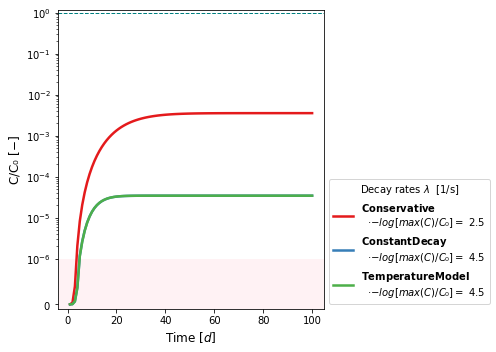

In [8]:
resetPickle()
caseDict['Gradient']['X'].value = 1.0E-4

## Build escenarios

### Conservaticve case
templateFile = getTemplate('TH_RDecay')
caseDict['BIOPARTICLE']['decayAq'].value = 0.0
buildSim("Conservative")

### Using bioparticle sandbox - TH
templateFile = getTemplate('TH_RSandbox_Const')
caseDict['BIOPARTICLE']['decayAq'].value = 3.5353E-06
buildSim("ConstantDecay")

### Using bioparticle sandbox - TH
templateFile = getTemplate('TH_RSandbox_Model')
caseDict['Temp']['Reference'].value  = 10.0
caseDict['Temp']['Atmosphere'].value = 10.0
caseDict['Temp']['Injection'].value  = 10.0
buildSim("TemperatureModel")

## Run and plot
mo.Model.runAllModels(nProcs=6)
legendTitle = "Decay rates $\lambda$  [1/s]"
plotResults()


## 1.2 Varying the system temperature

### 1.2.1 Using the worst gradient for conservative tracer

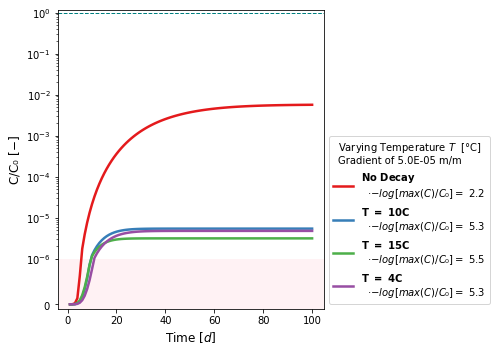

In [19]:
resetPickle()
caseDict['Gradient']['X'].value = 5.0E-5
caseDict['endTime'].value = 100.

## Build escenarios

templateFile = getTemplate('TH_RSandbox_Const')
caseDict['Temp']['Reference'].value  = 10.0
caseDict['Temp']['Atmosphere'].value = 10.0
caseDict['Temp']['Injection'].value  = 10.0
caseDict['BIOPARTICLE']['decayAq'].value = 0.0
buildSim("No_Decay")

templateFile = getTemplate('TH_RSandbox_Model')
caseDict['Temp']['Reference'].value  = 4.
caseDict['Temp']['Atmosphere'].value = 4.
caseDict['Temp']['Injection'].value  = 4.
buildSim("T_=_4C")

caseDict['Temp']['Reference'].value  = 10.
caseDict['Temp']['Atmosphere'].value = 10.
caseDict['Temp']['Injection'].value  = 10.
buildSim("T_=_10C")

caseDict['Temp']['Reference'].value  = 15.
caseDict['Temp']['Atmosphere'].value = 15.
caseDict['Temp']['Injection'].value  = 15.
buildSim("T_=_15C")

## Run and plot results
mo.Model.runAllModels(nProcs=6)
legendTitle = "Varying Temperature $T$  [°C]"\
    + "\nGradient of {:.1E} m/m".format(caseDict['Gradient']['X'].value)
plotResults()

### 1.2.2 Using a higher gradient

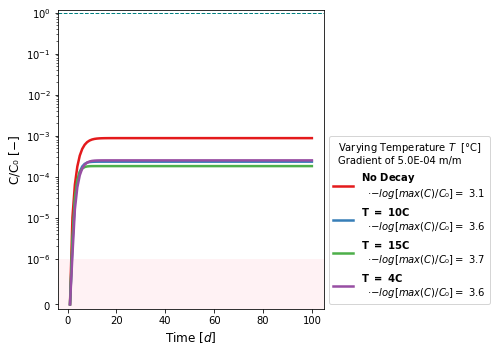

In [18]:
resetPickle()
caseDict['Gradient']['X'].value = 5.0E-4
caseDict['endTime'].value = 100.

## Build escenarios

templateFile = getTemplate('TH_RSandbox_Const')
caseDict['Temp']['Reference'].value  = 10.0
caseDict['Temp']['Atmosphere'].value = 10.0
caseDict['Temp']['Injection'].value  = 10.0
caseDict['BIOPARTICLE']['decayAq'].value = 0.0
buildSim("No_Decay")

templateFile = getTemplate('TH_RSandbox_Model')
caseDict['Temp']['Reference'].value  = 4.
caseDict['Temp']['Atmosphere'].value = 4.
caseDict['Temp']['Injection'].value  = 4.
buildSim("T_=_4C")

caseDict['Temp']['Reference'].value  = 10.
caseDict['Temp']['Atmosphere'].value = 10.
caseDict['Temp']['Injection'].value  = 10.
buildSim("T_=_10C")

caseDict['Temp']['Reference'].value  = 15.
caseDict['Temp']['Atmosphere'].value = 15.
caseDict['Temp']['Injection'].value  = 15.
buildSim("T_=_15C")

## Run and plot results
mo.Model.runAllModels(nProcs=6)
legendTitle = "Varying Temperature $T$  [°C]"\
    + "\nGradient of {:.1E} m/m".format(caseDict['Gradient']['X'].value)
plotResults()


## 1.3 Revisiting water table gradient

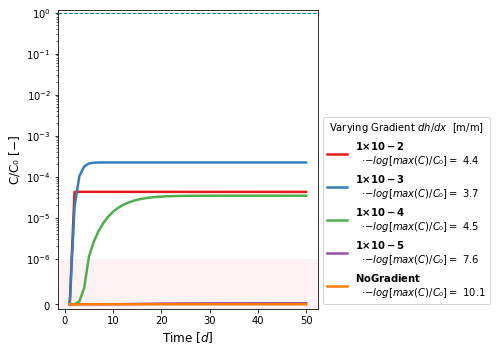

In [6]:
resetPickle()
caseDict['endTime'].value = 50.
templateFile = getTemplate('TH_RSandbox_Model')

## Build escenarios
caseDict['Gradient']['X'].value = 1.0E-2
buildSim("1×10-2")

caseDict['Gradient']['X'].value = 1.0E-3
buildSim("1×10-3")

caseDict['Gradient']['X'].value = 1.0E-4
buildSim("1×10-4")

caseDict['Gradient']['X'].value = 1.0E-5
buildSim("1×10-5")

caseDict['Gradient']['X'].value = 0.0
buildSim("NoGradient")

mo.Model.runAllModels(nProcs=6)
legendTitle = "Varying Gradient $dh/dx$  [m/m]"
plotResults()

### Narrow down the worst gradient

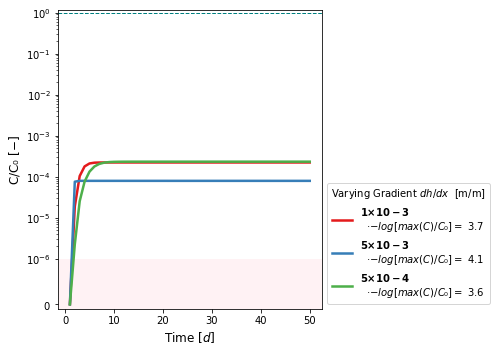

In [23]:
resetPickle()
caseDict['endTime'].value = 50.
templateFile = getTemplate('TH_RSandbox_Model')

## Build escenarios
caseDict['Gradient']['X'].value = 1.0E-3
buildSim("1×10-3")

caseDict['Gradient']['X'].value = 5.0E-3
buildSim("5×10-3")

caseDict['Gradient']['X'].value = 5.0E-4
buildSim("5×10-4")

mo.Model.runAllModels(nProcs=6)
legendTitle = "Varying Gradient $dh/dx$  [m/m]"
plotResults()


## 1.4 Varying temperature of injection water

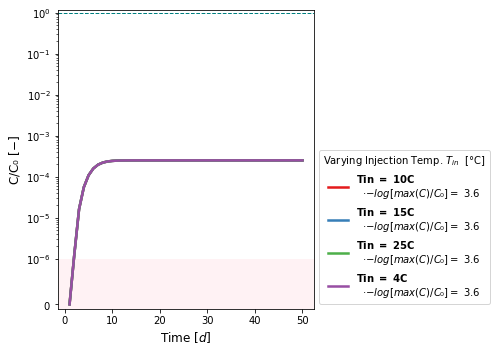

In [24]:
resetPickle()
caseDict['endTime'].value = 50.
caseDict['Gradient']['X'].value = 5.0E-4
caseDict['Temp']['Reference'].value  = 4.
caseDict['Temp']['Atmosphere'].value = 4.

# Build cases
caseDict['Temp']['Injection'].value  = 4.
buildSim("Tin_=_4C")

caseDict['Temp']['Injection'].value  = 10.
buildSim("Tin_=_10C")

caseDict['Temp']['Injection'].value  = 15.
buildSim("Tin_=_15C")

caseDict['Temp']['Injection'].value  = 25.
buildSim("Tin_=_25C")

# Run and plot results
mo.Model.runAllModels(nProcs=6)
legendTitle = "Varying Injection Temp. $T_{in}$  [°C]"
plotResults()

## 1.5 Varying permeability

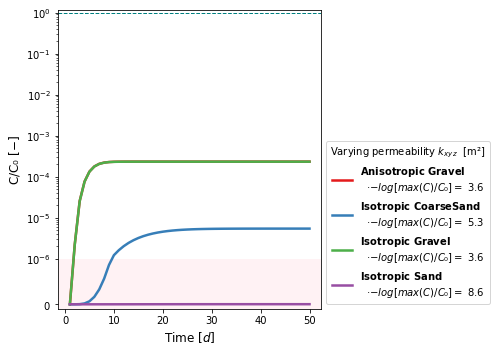

In [26]:
resetPickle()
caseDict['endTime'].value = 50.
caseDict['Gradient']['X'].value = 5.0E-4
templateFile = getTemplate('TH_RSandbox_Model')

## Build escenarios
caseDict['k']['X'].value = 1.0E-8
caseDict['k']['Y'].value = 1.0E-8
caseDict['k']['Z'].value = 1.0E-8
buildSim("Isotropic_Gravel")

## Build escenarios
caseDict['k']['X'].value = 1.0E-8
caseDict['k']['Y'].value = 1.0E-8
caseDict['k']['Z'].value = 1.0E-9
buildSim("Anisotropic_Gravel")

caseDict['k']['X'].value = 1.0E-9
caseDict['k']['Y'].value = 1.0E-9
caseDict['k']['Z'].value = 1.0E-9
buildSim("Isotropic_CoarseSand")

caseDict['k']['X'].value = 1.0E-10
caseDict['k']['Y'].value = 1.0E-10
caseDict['k']['Z'].value = 1.0E-10
buildSim("Isotropic_Sand")

mo.Model.runAllModels(nProcs=6)
legendTitle = "Varying permeability $k_{xyz}$  [m²]"
plotResults()

## 1.6 LineSource v. Point Source
### 1.6.1 When the well is perfectly aligned with the water table gradient

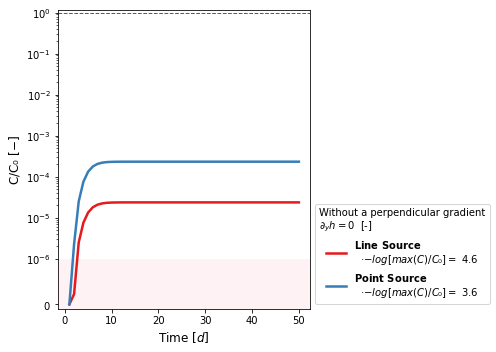

In [27]:
resetPickle()
templateFile = getTemplate('TH_RSandbox_Model_lineSource')
caseDict['endTime'].value = 50.
caseDict['Gradient']['X'].value = 5.0E-4

## Build escenarios
caseDict['inCoord']['Y'][1].value = caseDict['L']['Y'].value
caseDict['inCoord']['Y'][2].value = 0.0
buildSim("Line_Source")

caseDict['inCoord']['Y'][1].value = caseDict['L']['Y'].value / 2.0
caseDict['inCoord']['Y'][2].value = caseDict['L']['Y'].value / 2.0
buildSim("Point_Source")

mo.Model.runAllModels(nProcs=6)
legendTitle = "Without a perpendicular gradient\n$\partial_yh=0$  [-]"
plotResults()

### 1.6.2 With a gradient in Y direction

In [ ]:
resetPickle()
templateFile = getTemplate('TH_RSandbox_Model_lineSource')
caseDict['endTime'].value = 50.
caseDict['Gradient']['X'].value = 5.0E-4
caseDict['Gradient']['Y'].value = 5.0E-4

## Build escenarios
caseDict['inCoord']['Y'][1].value = caseDict['L']['Y'].value
caseDict['inCoord']['Y'][2].value = 0.0
buildSim("Line_Source")

caseDict['inCoord']['Y'][1].value = caseDict['L']['Y'].value / 2.0
caseDict['inCoord']['Y'][2].value = caseDict['L']['Y'].value / 2.0
buildSim("Point_Source")

mo.Model.runAllModels(nProcs=6)

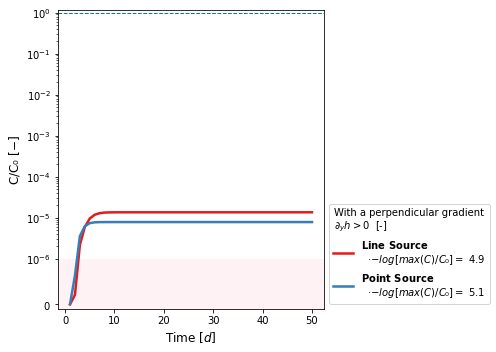

In [29]:
legendTitle = "With a perpendicular gradient\n$\partial_yh>0$  [-]"
plotResults()